In [102]:
from copy import deepcopy
from tqdm import tqdm
import random
from collections import defaultdict
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment

In [192]:
# Wrap the TrafficEnvironment into a gym-like environment
class TemporalDifference:
    def __init__(self, oiv = 0, alpha=0.1, epsilon=0.1, lambd=0.9, gamma=0.9):
        """
        Args:
        - lanes (int): Number of lanes (default is 5).
        - initial_distance (int): The distance from destination.
        - alpha (float): learning rate, between 0 and 1
        - epsilon (float): exploration rate between, 0 and 1
        - lambd (float): contribution of past rewards, between 0 and 1
        - gamma (float): discount factor, between 0 and 1
        - oiv (int/float): optimistic initial value
        """
        super().__init__()
        self.Env = environment.TrafficEnvironment()
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambd = lambd
        self.gamma = gamma
        self.oiv = oiv

        # Action space: 3 actions (0: move left, 1: stay, 2: move right)
        self.action_space = 3

        # use nested dictionaries for V, Q, E.
        # {state: [s_a1, s_a2, s_a3]}
        self.Q = defaultdict(lambda: np.zeros(self.action_space) + self.oiv)
        self.E = defaultdict(lambda: np.zeros(self.action_space) + self.oiv)
        
        # store 'best model'
        self.best_Q = None
        self.best_reward = float(-inf)

    def get_best_action(self, state: tuple):
        # if state not present, act random
        if state not in self.Q.keys():
            return random.randint(0,2)

        # get the dictionary of actions and their values for this state
        action_values = self.Q[state]
        # find the action with the maximum value
        best_action = np.argmax(action_values)
        return best_action

    # define epsilon greedypolicy
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0,2)
        else:
            return self.get_best_action(state)
    
    def train(self, num_episodes = 1000 , on_policy = True, save_model = False):

        #initialize list to store episode history
        total_reward_list = []
        total_steps_list = []

        for episode in tqdm(range(num_episodes)):
            episode_memory = []  # to be used when lambd = 1
            
            #reset episode, re-initialize E and total_reward
            state = self.Env.reset()
            state = tuple(state)
            done = False
            self.E.clear()
            steps = 0
            total_reward = 0

            #get first action
            action = self.epsilon_greedy_policy(state)

            while not done:
                #perform action
                next_state, reward, done = self.Env.step(action)

                #accumulate steps and reward
                steps += 1
                total_reward += reward

                #get next state and action
                next_state = tuple(next_state)
                next_action = self.epsilon_greedy_policy(next_state)
                
                #update tables(dictionaries)
                if self.lambd == 1:
                    episode_memory.append([state, action, reward])
                    state, action = next_state, next_action
                    state = tuple(state)
                    continue

                if on_policy:   # SARSA
                    delta = reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]
                else:           # Q-learning
                    best_next_action = self.get_best_action(next_state)
                    delta = reward + self.gamma * self.Q[next_state][best_next_action] - self.Q[state][action]
                
                # if TD(0), no need to perform epsilon decay
                if self.lambd == 0:
                    # update Q values
                    self.Q[state][action] += self.alpha * delta
                
                # if TD(lambd), update E & Q
                else:
                    self.E[state][action] += 1
                    for state in self.Q.keys():
                        for action in range(self.action_space):
                            self.Q[state][action] += self.alpha * delta * self.E[state][action]
                            self.E[state][action] *= self.gamma * self.lambd

                if done:
                    break

                # move to next state and action pair
                state, action = next_state, next_action
            
            # Append total rewards and steps after the episode ends
            total_reward_list.append(reward)
            total_steps_list.append(steps)
            
            if save_model == True:
                # Calculate average reward over last 100 episodes (or all if less than 100)
                window_size = min(100, len(total_reward_list))
                avg_reward = sum(total_reward_list[-window_size:]) / window_size
                
                # Save if best performance
                if avg_reward > self.best_reward:
                    self.best_reward = avg_reward
                    self.best_Q = dict(self.Q)  # Create a deep copy of current Q-values
                
            if self.lambd == 1:
                G = 0
                for state, action, reward in reversed(episode_memory):
                    G = reward + self.gamma * G
                    self.Q[state][action] += self.alpha * (G - self.Q[state][action])

        if episode % 1000 == 0:
            print(f'Sum of rewards at episode {episode} is {reward}' )

        return total_reward_list, total_steps_list

##### Visualise training

In [123]:
def plot_training_metrics(rewards, steps, window_size=50):
    """
    Plot training metrics (rewards and steps) with rolling mean (window_size)
    
    Args:
    rewards: list of episode rewards
    steps: list of episode steps
    window_size: size of rolling window for smoothing
    """
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create dataframes for easier plotting
    df_rewards = pd.DataFrame({
        'Episode': range(len(rewards)),
        'Reward': rewards,
        'Rolling Mean': pd.Series(rewards).rolling(window=window_size).mean()
    })
    
    df_steps = pd.DataFrame({
        'Episode': range(len(steps)),
        'Steps': steps,
        'Rolling Mean': pd.Series(steps).rolling(window=window_size).mean()
    })
    
    # Plot rewards
    sns.scatterplot(data=df_rewards, x='Episode', y='Reward', 
                   alpha=0.3, color='blue', ax=ax1, label='Reward')
    sns.lineplot(data=df_rewards, x='Episode', y='Rolling Mean',
                color='red', ax=ax1, linewidth=2, label=f'Rolling Mean (window={window_size})')
    ax1.set_title('Rewards per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    
    # Plot steps
    sns.scatterplot(data=df_steps, x='Episode', y='Steps',
                   alpha=0.3, color='blue', ax=ax2, label='Steps')
    sns.lineplot(data=df_steps, x='Episode', y='Rolling Mean',
                color='red', ax=ax2, linewidth=2, label=f'Rolling Mean (window={window_size})')
    ax2.set_title('Steps per Episode')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Number of Steps')
    
    # Adjust layout and display
    plt.tight_layout()
    return fig

#### SARSA

100%|██████████| 1000/1000 [00:55<00:00, 18.02it/s]


Sum of total rewards = -1650.200000000001
Average total reward per episode = -1.6502000000000001
Average steps per episode = 989.095


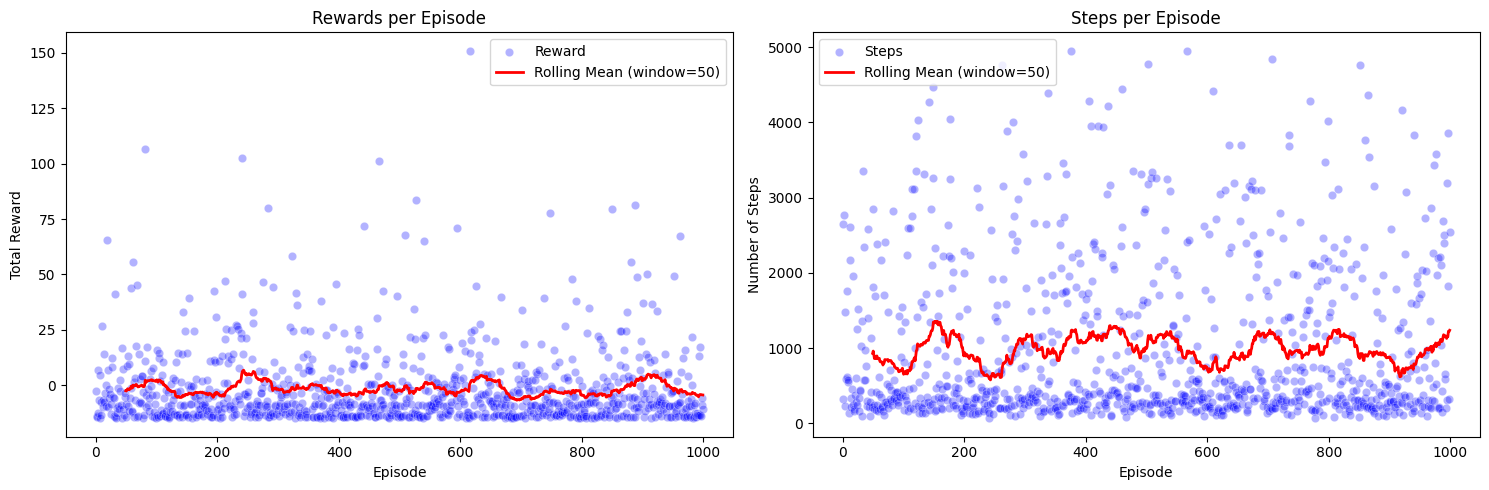

In [183]:
sarsa = TemporalDifference(oiv = 0, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9)
total_reward_list, total_steps_list = sarsa.train(num_episodes = 1000, on_policy = True, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

100%|██████████| 10000/10000 [07:15<00:00, 22.97it/s]


Sum of total rewards = -19309.800000000065
Average total reward per episode = -1.93098
Average steps per episode = 1072.3025


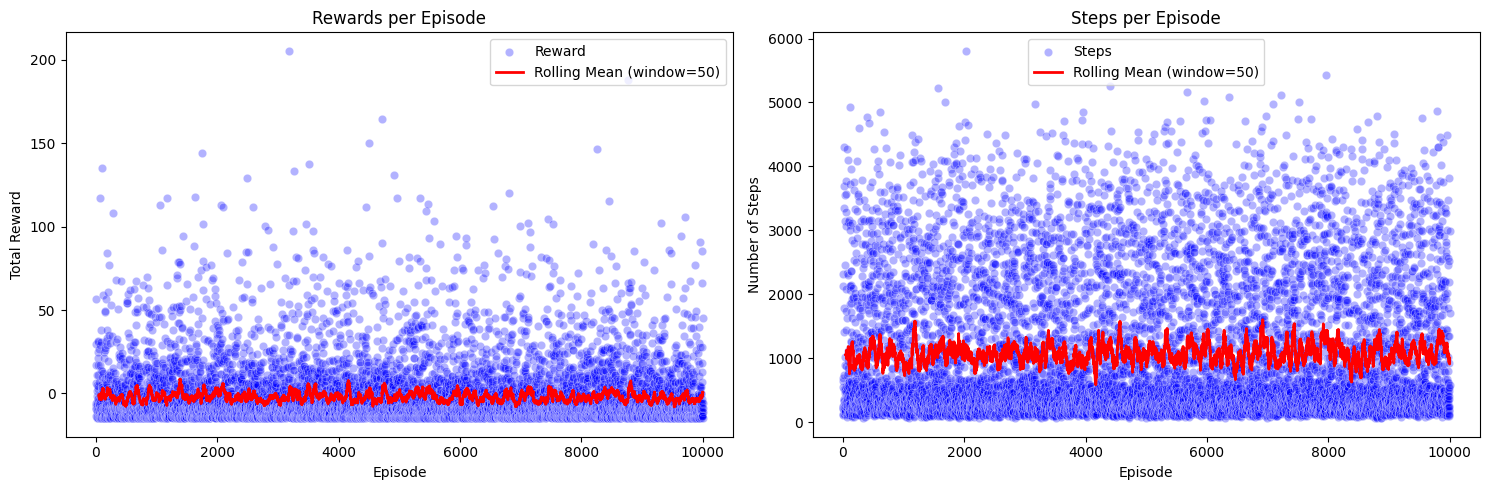

In [203]:
sarsa = TemporalDifference(oiv = 0, alpha=0.01, epsilon=0.1, lambd=0, gamma=0.95)
total_reward_list, total_steps_list = sarsa.train(num_episodes = 10000, on_policy = True, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

#### Q learning

100%|██████████| 1000/1000 [00:59<00:00, 16.68it/s]


Sum of total rewards = -1459.7999999999975
Average total reward per episode = -1.4598000000000002
Average steps per episode = 1019.871


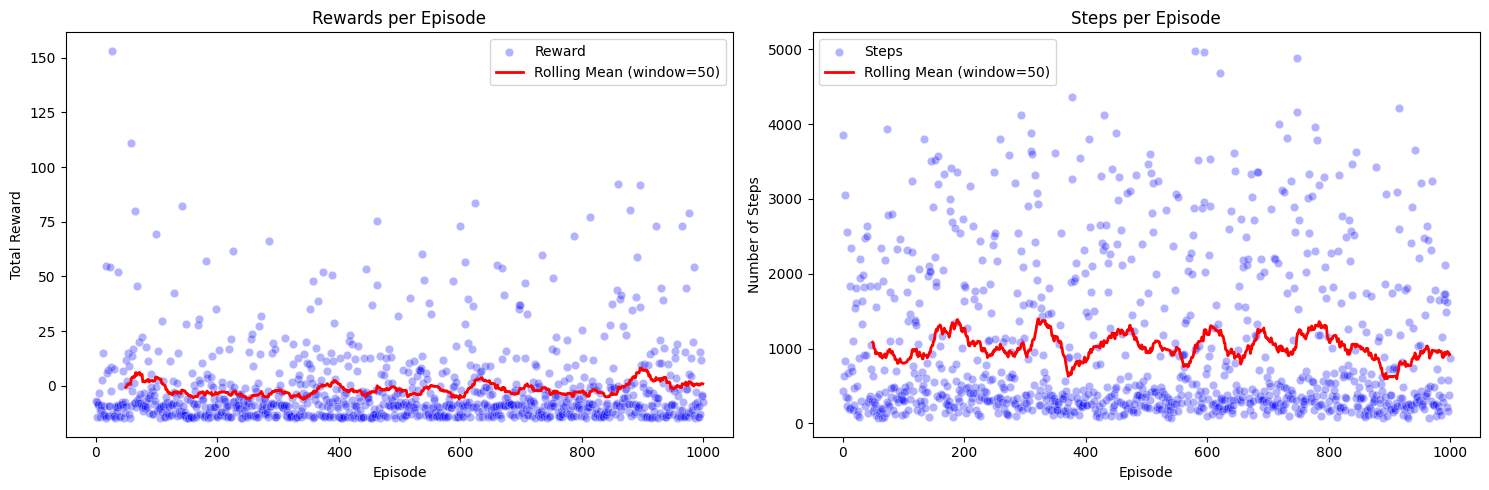

In [188]:
Q_learning = TemporalDifference(oiv = 0, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9)
total_reward_list, total_steps_list = Q_learning.train(num_episodes = 1000, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

100%|██████████| 1000/1000 [00:58<00:00, 17.13it/s]


Sum of total rewards = -1541.3000000000022
Average total reward per episode = -1.5413000000000001
Average steps per episode = 1013.822


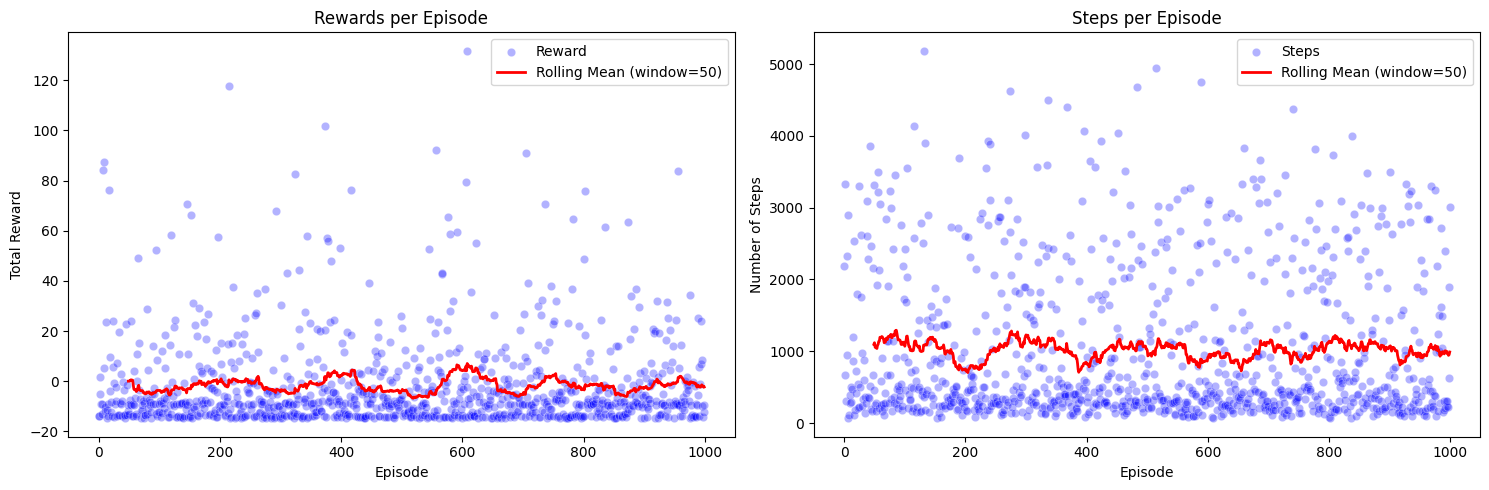

In [184]:
Q_learning = TemporalDifference(oiv = 0, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9)
total_reward_list, total_steps_list = Q_learning.train(num_episodes = 1000, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

100%|██████████| 2000/2000 [01:44<00:00, 19.21it/s]


Sum of total rewards = -5324.8999999999905
Average total reward per episode = -2.66245
Average steps per episode = 1093.925


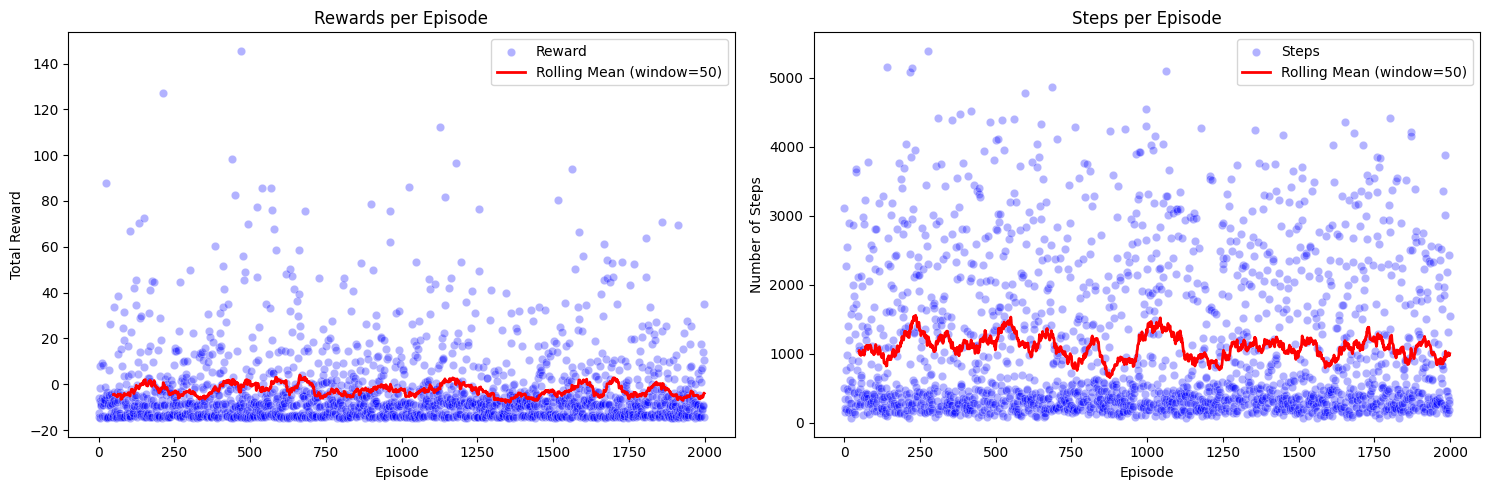

In [207]:
Q_learning = TemporalDifference(oiv = 0, alpha=0.05, epsilon=0.1, lambd=0, gamma=0.95)
total_reward_list, total_steps_list = Q_learning.train(num_episodes = 2000, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

100%|██████████| 10000/10000 [07:15<00:00, 22.96it/s]


Sum of total rewards = -18746.099999999933
Average total reward per episode = -1.8746099999999999
Average steps per episode = 1031.5387


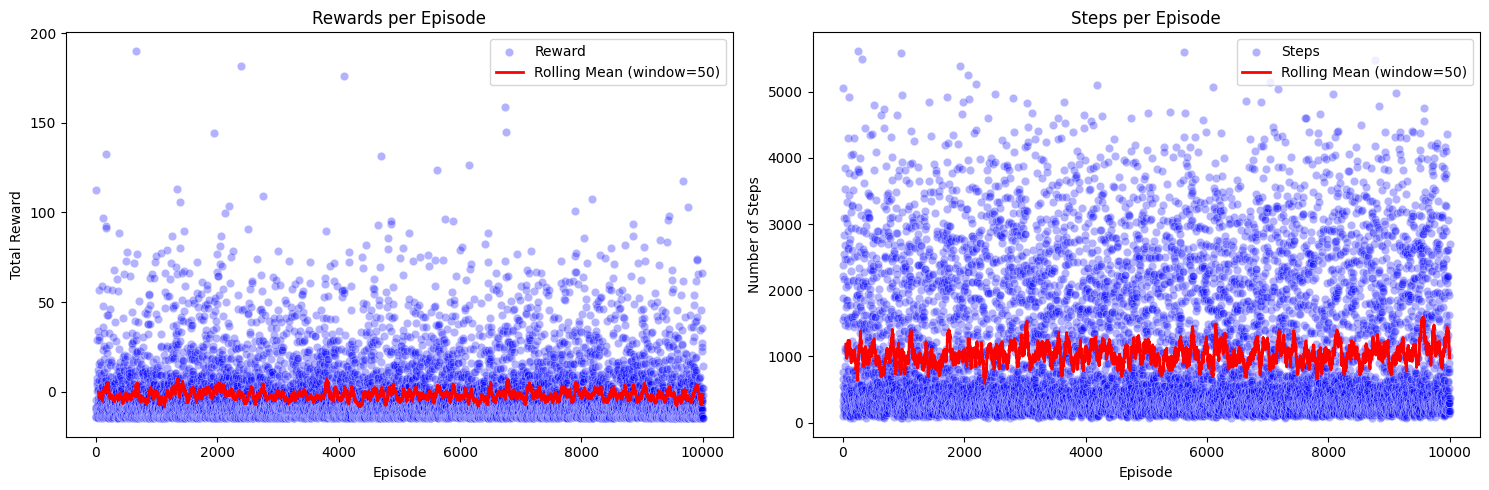

In [205]:
Q_learning = TemporalDifference(oiv = 0, alpha=0.0, epsilon=0.1, lambd=0, gamma=0.95)
total_reward_list, total_steps_list = Q_learning.train(num_episodes = 10000, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

#### Monte Carlo

100%|██████████| 1000/1000 [01:04<00:00, 15.47it/s]


Sum of total rewards = -3154.3999999999955
Average total reward per episode = -3.1544
Average steps per episode = 1128.775


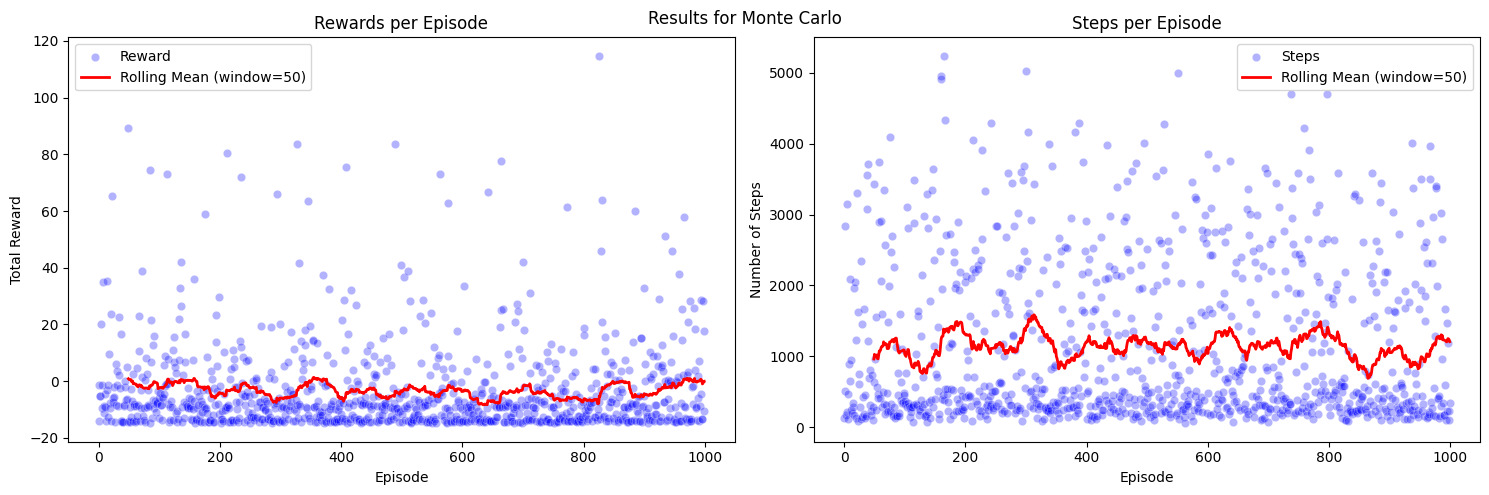

In [185]:
mc = TemporalDifference(oiv = 0, alpha=0.1, epsilon=0.1, lambd=1, gamma=0.9)
total_reward_list, total_steps_list = mc.train(num_episodes = 1000, on_policy = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.suptitle("Results for Monte Carlo")
plt.show()

100%|██████████| 1000/1000 [01:03<00:00, 15.84it/s]


Sum of total rewards = -2142.5000000000005
Average total reward per episode = -2.1425
Average steps per episode = 1093.176


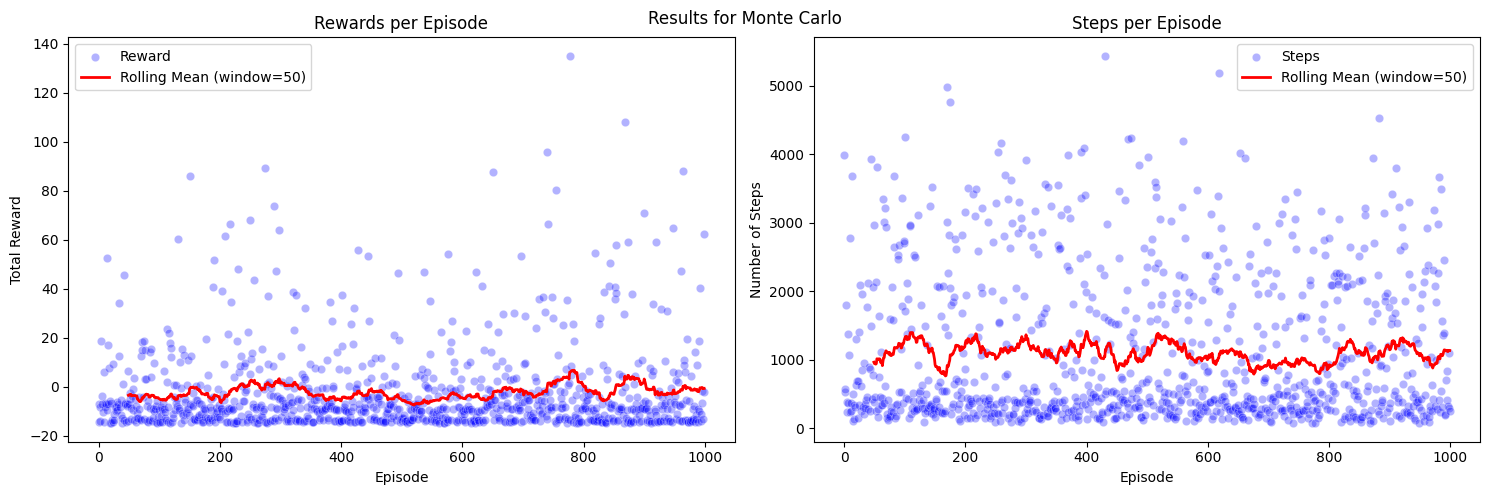

In [186]:
mc = TemporalDifference(oiv = 0, alpha=0.1, epsilon=0.1, lambd=1, gamma=0.9)
total_reward_list, total_steps_list = mc.train(num_episodes = 1000, save_model = False) #on_policy = True
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.suptitle("Results for Monte Carlo")
plt.show()

100%|██████████| 1000/1000 [00:47<00:00, 21.02it/s]


Sum of total rewards = -1874.5000000000005
Average total reward per episode = -1.8745000000000003
Average steps per episode = 1056.901


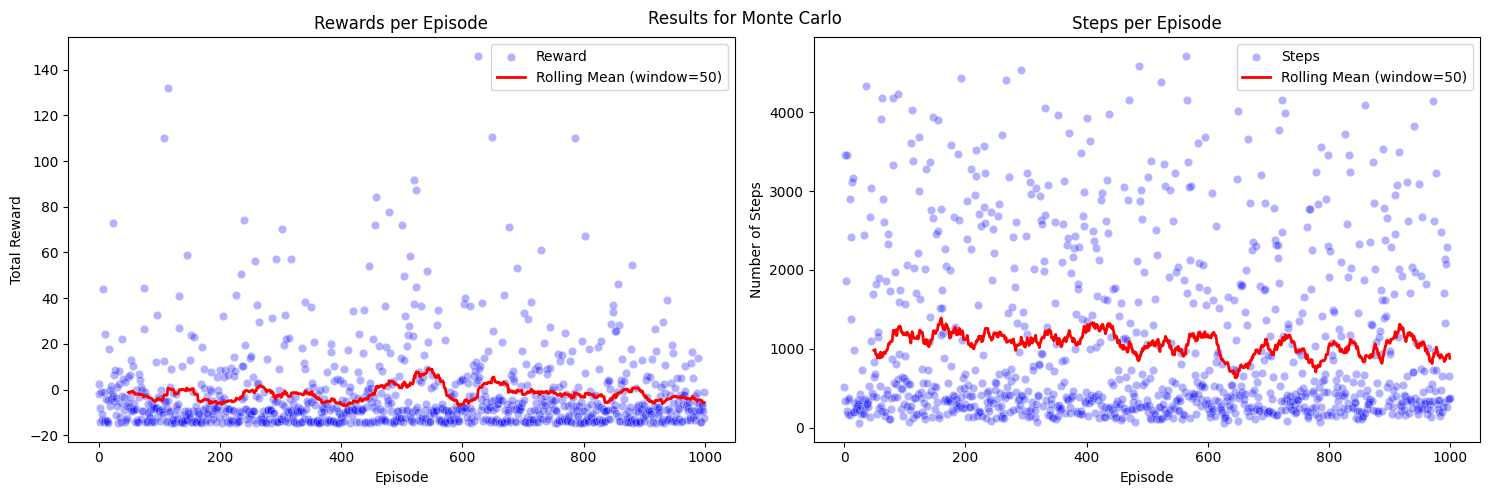

In [204]:
mc = TemporalDifference(oiv = 0, alpha=0.1, epsilon=0.1, lambd=1, gamma=0.95)
total_reward_list, total_steps_list = mc.train(num_episodes = 1000, save_model = False) #on_policy = True
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
plt.suptitle("Results for Monte Carlo")
plt.show()